# Task 1 (70 points):
## Part 1 (20 points):
This step involves downloading, preparing, and visualizing your
dataset. Create a convolutional base using a common pattern: a stack of Conv and
MaxPooling layers. Depending on the problem and the dataset you must decide what
pattern you want to use (i.e., how many Conv layers and how many pooling layers).
Please describe why you chose a particular pattern. Add the final dense layer(s).
Compile and train the model. Report the final evaluation and describe the metrics.

## Some Illustrations:

I follow this amazing notebook for this task:
https://www.kaggle.com/code/omarghazy56/cats-vs-dogs-pytorch

The dataset is from:
https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/code?datasetId=550917&searchQuery=pytorch

From the datacard:
This data set contains two class of images Cats and Dogs. This can be best utilized in a binary classification problem set in computer vision.
This dataset are collected from real-world scenarios, and needs to have propoper data preprocessing before inputting the data into the deep neural network.

In [1]:
! wget --no-check-certificate \
https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip\
-O ./cats_and_dogs_filtered.zip

--2024-03-15 02:06:00--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.30.158.37, 2a02:26f0:3500:f84::317f, 2a02:26f0:3500:f95::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.30.158.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>] 786.67M   347MB/s    in 2.3s    

2024-03-15 02:06:03 (347 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [824887076/824887076]



In [2]:
! unzip cats_and_dogs_filtered.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


import cv2
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import time
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
!ls

 cats_and_dogs_filtered.zip   CDLA-Permissive-2.0.pdf   PetImages  'readme[1].txt'   sample_data


# Data Analysis

An example of cat image

(375, 500, 3)


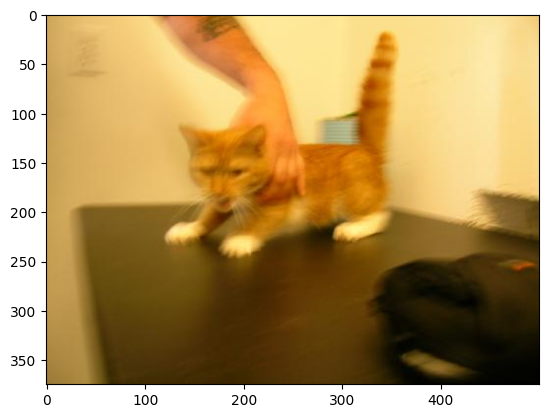

In [5]:
img = plt.imread('./PetImages/Cat/0.jpg')
print(img.shape)
plt.imshow(img);

An example of dog image

(199, 188, 3)


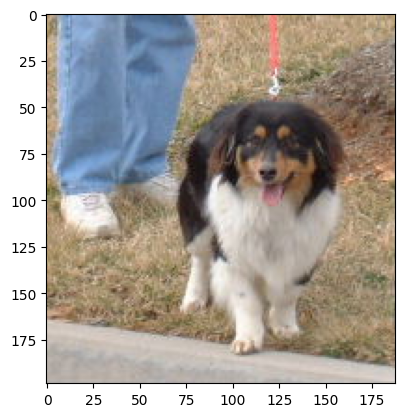

In [6]:
img = plt.imread('./PetImages/Dog/2.jpg')
print(img.shape)
plt.imshow(img);

In [7]:
def make_training_data():

    # Size of the image
    IMG_SIZE = 128

    # Directory location
    CATS = './PetImages/Cat/'
    DOGS = './PetImages/Dog/'

    # Labels for cats and dogs
    LABELS = {CATS:0, DOGS:1}

    # Initializing variables
    training_data = []
    catcount = 0
    dogcount = 0
    for label in LABELS:

        # Looping through each pictures
        for f in tqdm(os.listdir(label)):
            try:
                path = os.path.join(label, f)

                # Reading images and converting to RGB
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                #img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

                # Resizing images
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                # Getting the training data
                training_data.append([np.array(img), np.eye(2)[LABELS[label]]])

                # Checking distribution of data
                if label == CATS:
                    catcount += 1
                elif label == DOGS:
                    dogcount += 1

            except Exception as e:
                pass

        np.random.shuffle(training_data)
        #np.save("training_data_128.npy", self.training_data, dtype=object)
        print("Cats: ", catcount)
        print("Dogs: ", dogcount)
    return training_data


training_data = make_training_data()

100%|██████████| 12501/12501 [00:26<00:00, 471.77it/s]


Cats:  12476
Dogs:  0


100%|██████████| 12501/12501 [00:27<00:00, 452.88it/s]


Cats:  12476
Dogs:  12470


From the above, there are 12476 cat images, and 12470 dog images

In [8]:
# training data preprocessing
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(15),
    transforms.ToTensor(),
])
# testing data preprocessing
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        self.y = y
        if y is not None:
            self.y = torch.Tensor(y.numpy())
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [9]:
print(training_data[0])
torch.Tensor(training_data[0][0]).shape

[array([[[125, 138, 136],
        [124, 137, 135],
        [125, 138, 136],
        ...,
        [209, 212, 210],
        [209, 212, 210],
        [209, 212, 210]],

       [[121, 135, 133],
        [122, 135, 133],
        [122, 135, 133],
        ...,
        [210, 213, 211],
        [210, 213, 211],
        [210, 213, 211]],

       [[122, 135, 133],
        [124, 137, 135],
        [125, 138, 136],
        ...,
        [211, 214, 213],
        [211, 214, 213],
        [211, 214, 212]],

       ...,

       [[191, 192, 190],
        [180, 181, 179],
        [167, 168, 166],
        ...,
        [101, 127, 143],
        [ 93, 123, 140],
        [ 96, 125, 142]],

       [[179, 180, 178],
        [171, 172, 170],
        [160, 161, 159],
        ...,
        [100, 126, 142],
        [ 94, 124, 141],
        [100, 129, 146]],

       [[168, 169, 167],
        [162, 163, 162],
        [157, 158, 156],
        ...,
        [ 94, 120, 137],
        [100, 130, 147],
        [ 99, 127, 145]

torch.Size([128, 128, 3])

In [10]:
# Creating a tensor from a list of numpy.ndarrays is extremely slow
# so converting it first to np.array
# for i in training_data:
#   print(i[0].shape)
print(training_data[1848][0].shape)
X_np = np.array([i[0] for i in training_data])

print(X_np.shape)
# Create a tensor from the NumPy array
X = torch.from_numpy(X_np).view(-1, 128, 128, 3)
# print(X.shape)
X = torch.permute(X, (0, 3, 1, 2))
X = X.float()
print(X.shape)

#Scaling the features
# X = X / 255.0
#X = (( np.transpose(X, axis=(0, 3, 2, 1))- X.mean((2,3))) / np.transpose(X.std((2,3)), axis=(0, 3, 2, 1)))
#Compute mean and standard deviation along specified axes
mean = torch.mean(X, dim=(0, 2, 3))
std = torch.std(X, dim=(0, 2, 3))

# Normalize the tensor using computed mean and standard deviation
X = (X - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)

# Getting the target
y = torch.Tensor([i[1] for i in training_data])

(128, 128, 3)
(24946, 128, 128, 3)
torch.Size([24946, 3, 128, 128])


<ipython-input-10-39ff30aa6b96>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  y = torch.Tensor([i[1] for i in training_data])


In [11]:
print(X.shape)
print(y.shape)

torch.Size([24946, 3, 128, 128])
torch.Size([24946, 2])


In [12]:
y_label = []
real = torch.argmax(y)
for i in range(len(y)):
    real = torch.argmax(y[i])
    y_label.append(real.item())
y_label = torch.Tensor(y_label)
print('Cats :',(y_label == 0.).sum().item())
print('Dogs :',y_label.sum().item())

Cats : 12476
Dogs : 12470.0


In [13]:
#split train and test
val = int(len(X)*0.3)
train_x = X[:-val]
train_y = y_label[:-val]
val_x = X[-val:]
val_y = y_label[-val:]
print("Train size :",len(train_x))
print("Validation size :",len(val_x))

Train size : 17463
Validation size : 7483


In [14]:
batch_size=64

train_set = ImgDataset(train_x,train_y,train_transform)
test_set = ImgDataset(val_x,val_y,test_transform)

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size= batch_size, shuffle=False)

First, I mainly follow the notebook mentioned.
Also, I mainly follow a kernel size of 3, stride of 1 and padding of 1.
Kernel size of 3 is big enough to capture local features yet small enough to capture nuances. Stride of 1 makes sure that the model gather all the information. Padding of 1 makes sure that the kernel learns a complete 3x3 matrix when captures edges of the cat or dog.

Also, after channels, goes from 3 -> 64 -> 128 -> 256 -> 512 to condense information enough, and easier for the final dense layers to classifier the latent representation.

In [15]:
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
# torch.nn.MaxPool2d(kernel_size, stride, padding)
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # input [1, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128,2)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [16]:
#setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = Classifier().to(device)
cirection = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

cuda


In [17]:
#train
epochs = 10
v_loss = []
t_loss = []
t_acc = []
v_acc = []

for epoch in range(epochs):
    epoch_start_time = time.time()
    train_acc =0.0
    val_acc =0.0
    train_loss = 0.0
    val_loss =0.0
    model.train()
    for i,data in enumerate(train_loader):
        optimizer.zero_grad()
        x,y = data[0].to(device),data[1].to(device)
        # print(x.shape)
        y_pred = model(x)
        loss = cirection(y_pred,y.long())
        loss.backward()
        optimizer.step()
        train_acc +=np.sum(np.argmax(y_pred.cpu().data.numpy(),axis=1)== y.cpu().numpy())
        train_loss +=loss.item()

    model.eval()
    with torch.no_grad():
        for i,data in enumerate(test_loader):
            valx ,valy = data[0].to(device),data[1].to(device)
            val_pred = model(valx)
            batch_loss = cirection(val_pred,valy.long())
            val_acc +=np.sum(np.argmax(val_pred.cpu().data.numpy(),axis=1)== valy.cpu().numpy())
            val_loss +=batch_loss.item()
        t_loss.append(train_loss / train_set.__len__())
        v_loss.append(val_loss / test_set.__len__())
        t_acc.append(train_acc / train_set.__len__())
        v_acc.append(val_acc / test_set.__len__())
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, epochs, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/test_set.__len__(), val_loss/test_set.__len__()))

[001/010] 23.70 sec(s) Train Acc: 0.638607 Loss: 0.009915 | Val Acc: 0.663504 loss: 0.009364
[002/010] 21.80 sec(s) Train Acc: 0.690488 Loss: 0.009046 | Val Acc: 0.673259 loss: 0.009565
[003/010] 21.81 sec(s) Train Acc: 0.708527 Loss: 0.008625 | Val Acc: 0.641721 loss: 0.009995
[004/010] 21.78 sec(s) Train Acc: 0.742083 Loss: 0.008046 | Val Acc: 0.724709 loss: 0.008283
[005/010] 21.81 sec(s) Train Acc: 0.777186 Loss: 0.007362 | Val Acc: 0.722838 loss: 0.008821
[006/010] 21.84 sec(s) Train Acc: 0.809597 Loss: 0.006496 | Val Acc: 0.623146 loss: 0.014562
[007/010] 22.01 sec(s) Train Acc: 0.845216 Loss: 0.005488 | Val Acc: 0.745690 loss: 0.008127
[008/010] 21.95 sec(s) Train Acc: 0.876310 Loss: 0.004471 | Val Acc: 0.755446 loss: 0.008252
[009/010] 21.89 sec(s) Train Acc: 0.914677 Loss: 0.003310 | Val Acc: 0.704931 loss: 0.015063
[010/010] 21.87 sec(s) Train Acc: 0.941476 Loss: 0.002286 | Val Acc: 0.682614 loss: 0.018034


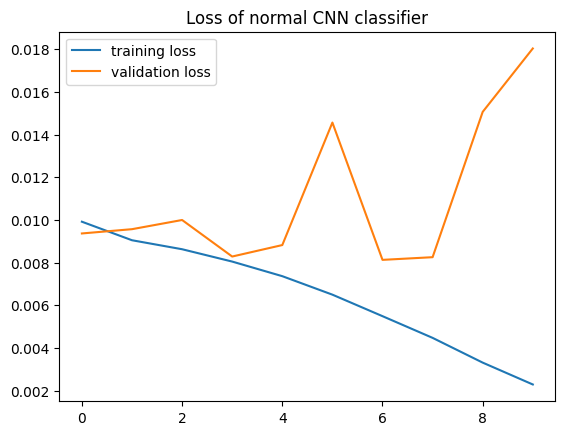

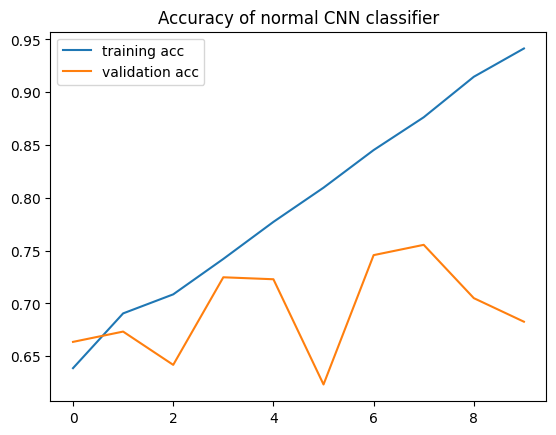

In [18]:
plt.title('Loss of normal CNN classifier')
plt.plot(t_loss, label='training loss')
plt.plot(v_loss, label='validation loss')
plt.legend()
plt.show()

plt.title('Accuracy of normal CNN classifier')
plt.plot(t_acc, label='training acc')
plt.plot(v_acc, label='validation acc')
plt.legend()
plt.show()

Here, I use traditional accuracy and loss, where accuracy measures the prediction performance, and loss measures the error of the model.

According to the accuracy, our CNN classifier overfits the training data a bit.

## Part 2 (25 points):
The following models are widely used for transfer learning because of
their performance and architectural innovations:
1. VGG (e.g., VGG16 or VGG19).
2. GoogLeNet (e.g., InceptionV3).
3. Residual Network (e.g., ResNet50).
4. MobileNet (e.g., MobileNetV2)
Choose any one of the above models to perform the classification task you did in Part 1.
Evaluate the results using the same metrics as in Part 1. Are there any differences? Why
or why not? Describe in detail.

## Using VGG16, and add MLP for classification

In [19]:
from torch import nn
import torchvision.models as models

vgg16_model = models.vgg16(pretrained=True)
vgg16_model = nn.Sequential(*list(vgg16_model.children())[:-1])

# Freeze the parameters of the pre-trained VGG16 layers
for param in vgg16_model.parameters():
    param.requires_grad = False

# Define the custom classifier
mlp = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(512 * 7 * 7, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 2),
)
model = nn.Sequential(vgg16_model, mlp).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 170MB/s]


In [20]:
#train
epochs = 10
v_loss = []
t_loss = []
t_acc = []
v_acc = []

for epoch in range(epochs):
    epoch_start_time = time.time()
    train_acc =0.0
    val_acc =0.0
    train_loss = 0.0
    val_loss =0.0
    model.train()
    for i,data in enumerate(train_loader):
        optimizer.zero_grad()
        x,y = data[0].to(device),data[1].to(device)
        # print(x.shape)
        y_pred = model(x)
        loss = cirection(y_pred,y.long())
        loss.backward()
        optimizer.step()
        train_acc +=np.sum(np.argmax(y_pred.cpu().data.numpy(),axis=1)== y.cpu().numpy())
        train_loss +=loss.item()

    model.eval()
    with torch.no_grad():
        for i,data in enumerate(test_loader):
            valx ,valy = data[0].to(device),data[1].to(device)
            val_pred = model(valx)
            batch_loss = cirection(val_pred,valy.long())
            val_acc +=np.sum(np.argmax(val_pred.cpu().data.numpy(),axis=1)== valy.cpu().numpy())
            val_loss +=batch_loss.item()
        t_loss.append(train_loss / train_set.__len__())
        v_loss.append(val_loss / test_set.__len__())
        t_acc.append(train_acc / train_set.__len__())
        v_acc.append(val_acc / test_set.__len__())
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, epochs, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/test_set.__len__(), val_loss/test_set.__len__()))

[001/010] 21.75 sec(s) Train Acc: 0.730917 Loss: 0.008618 | Val Acc: 0.765335 loss: 0.007517
[002/010] 22.31 sec(s) Train Acc: 0.778675 Loss: 0.007250 | Val Acc: 0.773086 loss: 0.007418
[003/010] 21.85 sec(s) Train Acc: 0.793735 Loss: 0.006756 | Val Acc: 0.771215 loss: 0.007584
[004/010] 21.97 sec(s) Train Acc: 0.808853 Loss: 0.006346 | Val Acc: 0.767206 loss: 0.007653
[005/010] 21.59 sec(s) Train Acc: 0.821394 Loss: 0.005918 | Val Acc: 0.777095 loss: 0.007530
[006/010] 21.51 sec(s) Train Acc: 0.832904 Loss: 0.005519 | Val Acc: 0.769477 loss: 0.008142
[007/010] 21.53 sec(s) Train Acc: 0.843154 Loss: 0.005206 | Val Acc: 0.776159 loss: 0.008701
[008/010] 21.53 sec(s) Train Acc: 0.852603 Loss: 0.004797 | Val Acc: 0.764399 loss: 0.008795
[009/010] 21.43 sec(s) Train Acc: 0.859875 Loss: 0.004519 | Val Acc: 0.765468 loss: 0.009442
[010/010] 21.53 sec(s) Train Acc: 0.869667 Loss: 0.004206 | Val Acc: 0.765602 loss: 0.009791


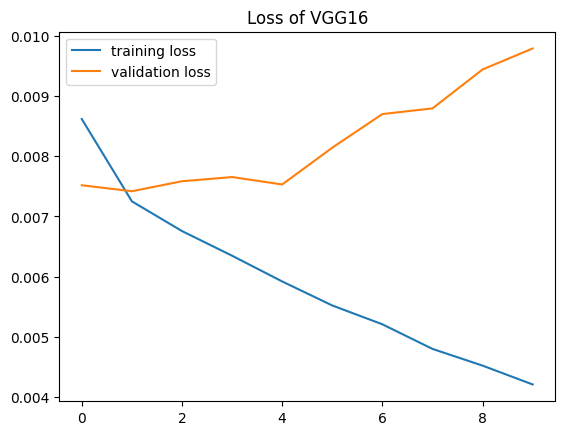

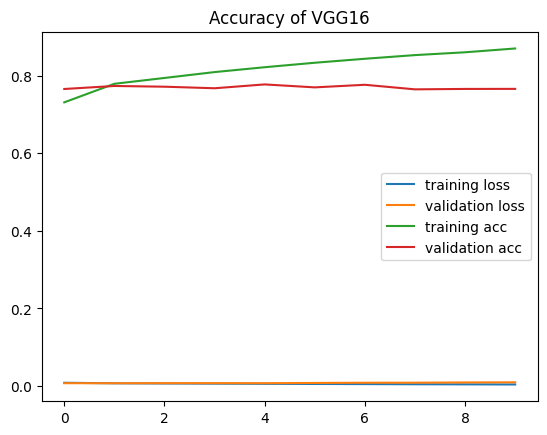

In [21]:
plt.title('Loss of VGG16')
plt.plot(t_loss, label='training loss')
plt.plot(v_loss, label='validation loss')
plt.legend()
plt.show()

plt.title('Accuracy of VGG16')
plt.plot(t_acc, label='training acc')
plt.plot(v_acc, label='validation acc')
plt.legend()
plt.show()

VGG16 is kind of robost to overfit, where the validation accuracy is higher than our CNN classifier. My guess is first VGG16 is bigger than our model, and then VGG16 has 2 or 3 convolutional layers stays at the same number of dimension (256 -> 256) that functions sort like of a regularizer instead of our CNN classifier directly goes from 256 -> 512.

##Part 3 (25 points):

Use data augmentation to increase the diversity of your dataset by
applying random transformations such as image rotation (you can use any other
technique as well). Repeat the process from part 1 with this augmented data. Did you
observe any difference in results?

## Illustrations:

Here, I do random horizontal flip and random rotation with 15 degrees.

In [22]:
# training data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])
# testing data preprocessing
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        self.y = y
        if y is not None:
            self.y = torch.Tensor(y.numpy())
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [23]:
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
# torch.nn.MaxPool2d(kernel_size, stride, padding)
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # input [1, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128,2)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [24]:
#setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = Classifier().to(device)
cirection = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

cuda


In [25]:
#train
epochs = 10
v_loss = []
t_loss = []
t_acc = []
v_acc = []

for epoch in range(epochs):
    epoch_start_time = time.time()
    train_acc =0.0
    val_acc =0.0
    train_loss = 0.0
    val_loss =0.0
    model.train()
    for i,data in enumerate(train_loader):
        optimizer.zero_grad()
        x,y = data[0].to(device),data[1].to(device)
        # print(x.shape)
        y_pred = model(x)
        loss = cirection(y_pred,y.long())
        loss.backward()
        optimizer.step()
        train_acc +=np.sum(np.argmax(y_pred.cpu().data.numpy(),axis=1)== y.cpu().numpy())
        train_loss +=loss.item()

    model.eval()
    with torch.no_grad():
        for i,data in enumerate(test_loader):
            valx ,valy = data[0].to(device),data[1].to(device)
            val_pred = model(valx)
            batch_loss = cirection(val_pred,valy.long())
            val_acc +=np.sum(np.argmax(val_pred.cpu().data.numpy(),axis=1)== valy.cpu().numpy())
            val_loss +=batch_loss.item()
        t_loss.append(train_loss / train_set.__len__())
        v_loss.append(val_loss / test_set.__len__())
        t_acc.append(train_acc / train_set.__len__())
        v_acc.append(val_acc / test_set.__len__())
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, epochs, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/test_set.__len__(), val_loss/test_set.__len__()))

[001/010] 21.70 sec(s) Train Acc: 0.626639 Loss: 0.010133 | Val Acc: 0.608579 loss: 0.010244
[002/010] 21.88 sec(s) Train Acc: 0.684705 Loss: 0.009184 | Val Acc: 0.677536 loss: 0.009291
[003/010] 21.90 sec(s) Train Acc: 0.707954 Loss: 0.008735 | Val Acc: 0.649739 loss: 0.010612
[004/010] 21.95 sec(s) Train Acc: 0.740594 Loss: 0.008118 | Val Acc: 0.716157 loss: 0.008655
[005/010] 21.92 sec(s) Train Acc: 0.771746 Loss: 0.007428 | Val Acc: 0.747294 loss: 0.008224
[006/010] 22.32 sec(s) Train Acc: 0.804100 Loss: 0.006643 | Val Acc: 0.604303 loss: 0.014904
[007/010] 21.77 sec(s) Train Acc: 0.835080 Loss: 0.005656 | Val Acc: 0.759588 loss: 0.007782
[008/010] 22.95 sec(s) Train Acc: 0.875050 Loss: 0.004521 | Val Acc: 0.779233 loss: 0.007769
[009/010] 22.22 sec(s) Train Acc: 0.907175 Loss: 0.003492 | Val Acc: 0.774823 loss: 0.007584
[010/010] 22.73 sec(s) Train Acc: 0.941133 Loss: 0.002377 | Val Acc: 0.811573 loss: 0.007487


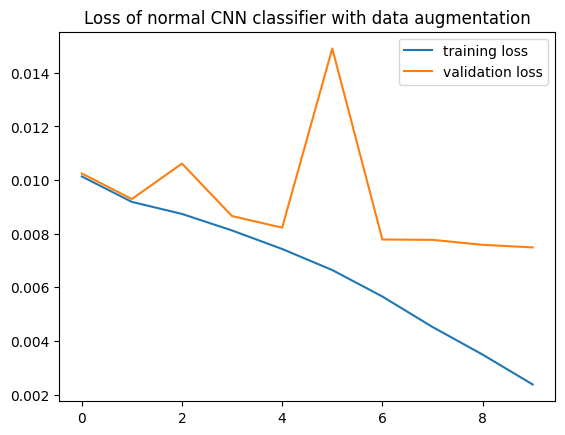

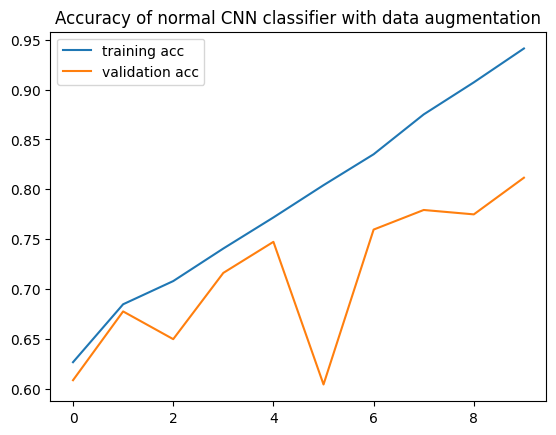

In [26]:
plt.title('Loss of normal CNN classifier with data augmentation')
plt.plot(t_loss, label='training loss')
plt.plot(v_loss, label='validation loss')
plt.legend()
plt.show()

plt.title('Accuracy of normal CNN classifier with data augmentation')
plt.plot(t_acc, label='training acc')
plt.plot(v_acc, label='validation acc')
plt.legend()
plt.show()

Comparing to part 1 without data augmentation, we can see that the validation accuracy significantly increases because data augmentation provides more variants to the dataset, such also serves as a nice regularizer to prevent model overfitting.

# Task 2 (30 points):
## Part 1 (15 points):
Variational Autoencoder (VAE): Here is a complete implementation
of a VAE in TensorFlow: https://www.tensorflow.org/tutorials/generative/cvae
PyTorch implementation is fine too.
Following these steps try generating images using the same encoder-decoder architecture using
a different Image dataset (other than MNIST).

I am using CIFAR10 dataset rather than MNIST. For CIFAR10, I reference on this link: https://www.tensorflow.org/tutorials/images/cnn

In [1]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ts0asfch
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-ts0asfch
  Resolved https://github.com/tensorflow/docs to commit b64768499123da8b2253a534277d62e20de3ec73
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.2.5.73858-py3-none-any.whl size=182442 sha256=47b833b4667c7ab8caef35bad203bcd1fde8d9b791bed3d964904563af8169ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-klgzvv3_/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [2]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [47]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# # Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

Visualizing the data

In [48]:
def preprocess_images(images):
  # images = images.reshape((images.shape[0], 28, 28, 3)) / 255.
  # return np.where(images > .5, 1.0, 0.0).astype('float32')
  return tf.cast(images, tf.float32)

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

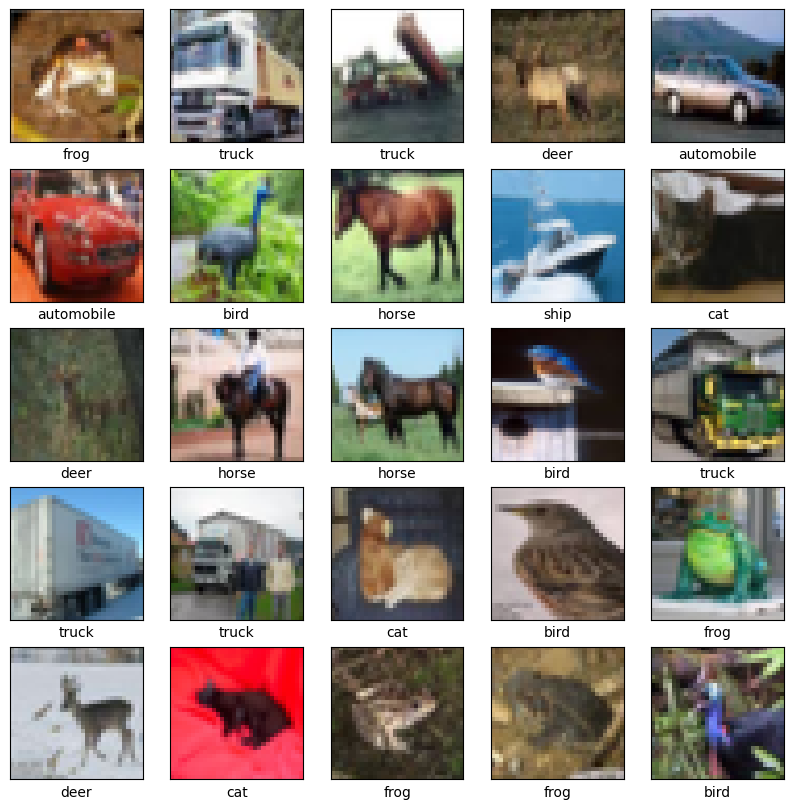

In [49]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [50]:
print(train_images.shape, test_images.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [111]:
train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size = 32
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [82]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=8*8*64, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(8, 8, 64)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [83]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  # print(mean.shape, logvar.shape)
  z = model.reparameterize(mean, logvar)
  # print(z.shape)
  x_logit = model.decode(z)
  # print(x_logit.shape)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [84]:
epochs = 30
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [85]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    # Remove the selection of a specific channel and the cmap argument
    plt.imshow(predictions[i, :, :, :])  # Ensure pixel values are in [0, 1]
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.tight_layout()
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [86]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 30, Test set ELBO: -1958.1099853515625, time elapse for current epoch: 5.49830436706543


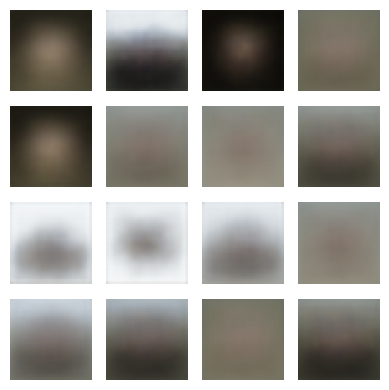

In [87]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

# Display a image

In [88]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

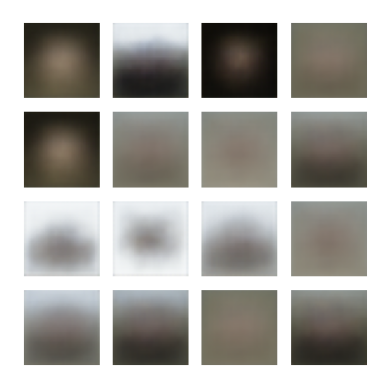

In [89]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

#Part 2 (15 points):
Generative Adversarial Networks (GANs): Repeat part 1 (use same
dataset) and implement a GAN model to generate high quality synthetic images. You may
follow steps outlined here: https://www.tensorflow.org/tutorials/generative/dcgan

In [115]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf

from IPython import display

In [116]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((8, 8, 256)))

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model


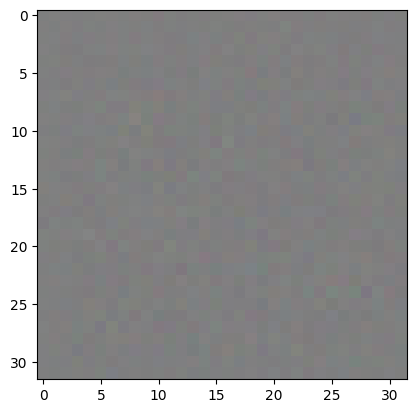

In [117]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image = (generated_image + 1)/2 # because of tanh

plt.imshow(generated_image[0, :, :, :])

In [118]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [119]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.0605453]], shape=(1, 1), dtype=float32)


In [120]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [121]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [122]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [123]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [124]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [125]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
BATCH_SIZE = batch_size

In [126]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [127]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [132]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :, :] + 1)/2)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

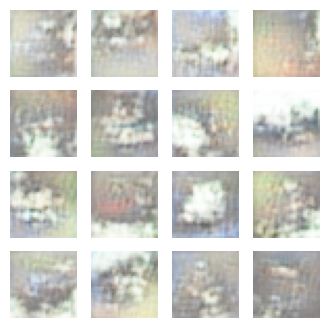

In [133]:
train(train_dataset, EPOCHS)

#Task for 6000 level (Graduate level only): 100 points
Medical Image Segmentation is an important problem in healthcare domain. Polyp recognition
and segmentation is one field which helps doctors identify polyps from colonoscope images.
CVC-Clinic database consists of frames extracted from colonoscopy videos. The dataset contains
several examples of polyp frames & corresponding ground truth for them.
The Ground Truth image consists of a mask corresponding to the region covered by the polyp in
the image. The data is available in both .png and .tiff format here: https://polyp.grand-
challenge.org/CVCClinicDB/
Consider this task as a minor research project in which you should research the existing models
used (https://paperswithcode.com/dataset/cvc-clinicdb ) to identify polyps from these images.
Report on the key findings and the evaluation metrics used for this problem. Variants of the
Unet architecture are often used to solve this problem. Implement either Unet or any of its
variants (Unet++, ResUnet etc.) to segment the polyp images. This may be a computation
intensive task (requiring GPUs). In case you do not have access to GPUs simply reduce your
training data size to train your model. Report your results, compare and contrast these results
with at least 2 of the other research paper results.

For this dataset, I am following https://www.kaggle.com/code/qonitaauliahimmah/attention-gate-spatial-se-u-net, which is Attention Gate Spatial SE U-net.

In [134]:
!unzip CVC-clinicDB.zip

Archive:  CVC-clinicDB.zip
   creating: CVC-clinicDB/
  inflating: __MACOSX/._CVC-clinicDB  
   creating: CVC-clinicDB/TIF/
  inflating: __MACOSX/CVC-clinicDB/._TIF  
   creating: CVC-clinicDB/PNG/
  inflating: __MACOSX/CVC-clinicDB/._PNG  
  inflating: CVC-clinicDB/metadata.csv  
  inflating: __MACOSX/CVC-clinicDB/._metadata.csv  
  inflating: CVC-clinicDB/class_dict.csv  
  inflating: __MACOSX/CVC-clinicDB/._class_dict.csv  
   creating: CVC-clinicDB/TIF/Original/
  inflating: __MACOSX/CVC-clinicDB/TIF/._Original  
   creating: CVC-clinicDB/TIF/Ground Truth/
  inflating: __MACOSX/CVC-clinicDB/TIF/._Ground Truth  
   creating: CVC-clinicDB/PNG/Original/
  inflating: __MACOSX/CVC-clinicDB/PNG/._Original  
   creating: CVC-clinicDB/PNG/Ground Truth/
  inflating: __MACOSX/CVC-clinicDB/PNG/._Ground Truth  
  inflating: CVC-clinicDB/TIF/Original/304.tif  
  inflating: __MACOSX/CVC-clinicDB/TIF/Original/._304.tif  
  inflating: CVC-clinicDB/TIF/Original/462.tif  
  inflating: __MACOSX/CVC-c

In [135]:
import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
import cv2
import time
import os
import h5py

from keras.models import Model
from keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, add, multiply, Lambda
from keras.layers import AveragePooling2D, average, UpSampling2D, Dropout
from keras.initializers import glorot_normal, random_normal, random_uniform
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda,Conv1D

from keras import backend as K
from keras.layers import BatchNormalization
from keras.models import load_model

import numpy as np
import tensorflow as tf
from keras.layers import GlobalAveragePooling2D, Reshape, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve # roc curve tools
from sklearn.model_selection import train_test_split

In [136]:
import os

# Create directories
os.makedirs('ProgressFull', exist_ok=True)
os.makedirs(f'ModelSaveTensorFlow', exist_ok=True)

In [137]:
# Set the model parameters

img_size = 256
dataset_type = 'cvc-clinicdb' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
learning_rate = 1e-4
seed_value = 58800
filters = 16 # Number of filters, the paper presents the results with 17 and 34
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

ct = datetime.now()

model_type = "Attention Gate Spatial SE U-net"

progress_path = 'ProgressFull/' + dataset_type + '_progress_csv_' + model_type + '_filters_' + str(filters) +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + dataset_type + '_progress_' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + dataset_type + '_progress_plot_' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + dataset_type + '/' + model_type + '_filters_' + str(filters) + '_' + str(ct)

EPOCHS = 75
min_loss_for_saving = 0.2

In [143]:
!pwd

/content


In [144]:
import glob

import numpy as np
from PIL import Image
from skimage.io import imread
from tqdm import tqdm

folder_path = "/content/CVC-clinicDB/TIF/"  # Add the path to your data directory

def load_data(img_height, img_width, images_to_be_loaded, dataset):
    IMAGES_PATH = folder_path + 'Original/'
    MASKS_PATH = folder_path + 'Ground Truth/'

    if dataset == 'kvasir':
        train_ids = glob.glob(IMAGES_PATH + "*.jpg")

    if dataset == 'cvc-clinicdb':
        train_ids = glob.glob(IMAGES_PATH + "*.tif")

    if dataset == 'cvc-colondb' or dataset == 'etis-laribpolypdb':
        train_ids = glob.glob(IMAGES_PATH + "*.png")

    if images_to_be_loaded == -1:
        images_to_be_loaded = len(train_ids)

    X_train = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.float32)
    Y_train = np.zeros((images_to_be_loaded, img_height, img_width), dtype=np.uint8)

    print('Resizing training images and masks: ' + str(images_to_be_loaded))
    for n, id_ in tqdm(enumerate(train_ids)):
        if n == images_to_be_loaded:
            break

        image_path = id_
        mask_path = image_path.replace("images", "masks")

        image = imread(image_path)
        mask_ = imread(mask_path)

        mask = np.zeros((img_height, img_width), dtype=np.bool_)

        pillow_image = Image.fromarray(image)

        pillow_image = pillow_image.resize((img_height, img_width))
        image = np.array(pillow_image)

        X_train[n] = image / 255

        pillow_mask = Image.fromarray(mask_)
        pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.LANCZOS)
        mask_ = np.array(pillow_mask)

        for i in range(img_height):
            for j in range(img_width):
                if (mask_[i, j] >= 127).any():
                    mask[i, j] = 1

        Y_train[n] = mask

    Y_train = np.expand_dims(Y_train, axis=-1)

    return X_train, Y_train

In [145]:
# Loading the data

X, Y = load_data(img_size, img_size, -1, 'cvc-clinicdb')

Resizing training images and masks: 612


612it [02:56,  3.47it/s]


In [146]:
# Splitting the data, seed for reproducibility

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)

In [147]:
import cv2 as cv

x_train_augmented = np.empty((2 * x_train.shape[0], *x_train.shape[1:]))
y_train_augmented = np.empty((2 * y_train.shape[0], *y_train.shape[1:]))

for i in range(x_train.shape[0]):
    x_train_augmented[i] = x_train[i]

    # Flip horizontally using cv2.flip for RGB images
    x_flipped = cv.flip(x_train[i], 1)
    x_train_augmented[i + x_train.shape[0]] = x_flipped

    y_train_augmented[i] = y_train[i]  # Add a singleton channel dimension if needed

    # Flip horizontally using cv2.flip for corresponding labels
    y_flipped = cv.flip(y_train[i], 1)
    y_train_augmented[i + y_train.shape[0]] = y_flipped[:, :, np.newaxis]  # Add a singleton channel dimension if needed

In [148]:
x_train_augmented.shape

(976, 256, 256, 3)

In [149]:
# Defining the augmentations

aug_train = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        ug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(ug['image'])
        y_train_out.append(ug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [150]:
import keras.backend as K
import tensorflow as tf


def dice_metric_loss(ground_truth, predictions, smooth=1e-6):
    ground_truth = K.cast(ground_truth, tf.float32)
    predictions = K.cast(predictions, tf.float32)
    ground_truth = K.flatten(ground_truth)
    predictions = K.flatten(predictions)
    intersection = K.sum(predictions * ground_truth)
    union = K.sum(predictions) + K.sum(ground_truth)

    dice = (2. * intersection + smooth) / (union + smooth)

    return 1 - dice

In [151]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code
kinit = 'glorot_normal'

def expend_as(tensor, rep,name):
    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
    return my_repeat

def AttnGatingBlock(x, g, inter_shape, name):
    shape_x = K.int_shape(x)  # 32
    shape_g = K.int_shape(g)  # 16

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name)(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3],  name)
    y = multiply([upsample_psi, x], name='q_attn'+name)

    result = Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name)(y)
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn

def UnetGatingSignal(input, is_batchnorm, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = K.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same",  kernel_initializer=kinit, name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name = name + '_act')(x)
    return x

def squeeze_excite_block(input_tensor, ratio=16):
    ''' Create a channel-wise squeeze-excite block '''
    init = input_tensor
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = K.int_shape(init)[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x

def UnetConv2DWithSE(input, outdim, is_batchnorm, name):
    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu',name=name + '_1_act')(x)

    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_act')(x)

    x = squeeze_excite_block(x)  # Add SE block
    return x

# Modifikasi pada fungsi UnetConv2D
def UnetConv2D(input, outdim, is_batchnorm, name):
    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_1_bn')(x)
    x = Activation('relu',name=name + '_1_act')(x)

    x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_act')(x)
    return x

def spatial_attention(input_feature):
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature._keras_shape[1]
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def attn_unet_with_se(opt, input_size, filter_num=16):
    inputs = Input(shape=input_size)
    conv1 = UnetConv2DWithSE(inputs, filter_num, is_batchnorm=True, name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = UnetConv2DWithSE(pool1, 2*filter_num, is_batchnorm=True, name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = UnetConv2DWithSE(pool2, 4*filter_num, is_batchnorm=True, name='conv3')
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = UnetConv2DWithSE(pool3, 8*filter_num, is_batchnorm=True, name='conv4')
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    #bridge
    center = UnetConv2DWithSE(pool4, 16*filter_num, is_batchnorm=True, name='center')
    center = spatial_attention(center)

    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv4, g1, 8*filter_num, '_1')
    up1 = UpSampling2D(size=(2, 2))(center)  # Upsample the ASPP block
    up1 = Concatenate(axis=3)([up1, attn1])
    up_conv1 = Conv2D(8*filter_num, (3, 3), activation='relu', padding='same', kernel_initializer=kinit, name='up_conv1')(up1)

    g2 = UnetGatingSignal(up_conv1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv3, g2, 4*filter_num, '_2')
    up2 = UpSampling2D(size=(2, 2))(up_conv1)
    up2 = Concatenate(axis=3)([up2, attn2])
    up_conv2 = Conv2D(4*filter_num, (3, 3), activation='relu', padding='same', kernel_initializer=kinit, name='up_conv2')(up2)

    g3 = UnetGatingSignal(up_conv2, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv2, g3, 2*filter_num, '_3')
    up3 = UpSampling2D(size=(2, 2))(up_conv2)
    up3 = Concatenate(axis=3)([up3, attn3])
    up_conv3 = Conv2D(2*filter_num, (3, 3), activation='relu', padding='same', kernel_initializer=kinit, name='up_conv3')(up3)

    up4 = UpSampling2D(size=(2, 2))(up_conv3)
    up4 = Concatenate(axis=3)([up4, conv1])
    up_conv4 = Conv2D(filter_num, (3, 3), activation='relu', padding='same', kernel_initializer=kinit, name='up_conv4')(up4)

    out = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=kinit, name='final')(up_conv4)

    model = Model(inputs=[inputs], outputs=[out], name='Attention_Gate_Spatial_SE_UNet')
    return model

In [152]:
# Placeholder values, replace them with your actual values
opt = 'adam'  # Replace with your optimizer choice
input_size = (256, 256, 3)  # Replace with your input size
# lossfxn = 'binary_crossentropy'  # Replace with your loss function choice

# Create an instance of attn_reg with the provided arguments
model = attn_unet_with_se(opt, input_size)

# Choose an arbitrary input shape (adjust this according to your actual input shape)
input_shape = (256, 256, 3)

# Build the model with the chosen input shape
model.build((None,) + input_shape)

# Print the model summary
model.summary()

Model: "Attention_Gate_Spatial_SE_UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_1 (Conv2D)            (None, 256, 256, 16)         448       ['input_21[0][0]']            
                                                                                                  
 conv1_1_bn (BatchNormaliza  (None, 256, 256, 16)         64        ['conv1_1[0][0]']             
 tion)                                                                                            
                                                                                                  
 conv1_1_act (Activation)    (None, 256, 256, 16)         0         [

In [154]:

# Compiling the model

model.compile(optimizer=optimizer, loss=dice_metric_loss)

In [155]:
train_loss = []
val_loss = []

# Training the model

step = 0

for epoch in range (0, EPOCHS):

    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1

    # Convert mask_augmented to float32
#     mask_augmented = mask_augmented.astype('float32')
    image_augmented, mask_augmented = augment_images()

    csv_logger = CSVLogger(progress_path, append=True, separator=';')

    history = model.fit(x=x_train_augmented, y=y_train_augmented, epochs=1, shuffle=True,batch_size=16, validation_data=(x_valid, y_valid), verbose=1, callbacks=[csv_logger])

     # Append the training and validation loss to the lists
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])

    prediction_valid = model.predict(x_valid, verbose=0)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))

    prediction_test = model.predict(x_test, verbose=0)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))

    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')

    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save(model_path)

    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 0
Learning Rate: 0.0001
61/61 [==============================] - 21s 96ms/step - loss: 0.1377 - val_loss: 0.6833
Loss Validation: 0.6830699
Loss Test: 0.6880077
Training, epoch 1
Learning Rate: 0.0001
61/61 [==============================] - 4s 61ms/step - loss: 0.0438 - val_loss: 0.9167
Loss Validation: 0.9166477
Loss Test: 0.9171174
Training, epoch 2
Learning Rate: 0.0001
61/61 [==============================] - 4s 61ms/step - loss: 0.0385 - val_loss: 0.9552
Loss Validation: 0.9552116
Loss Test: 0.95437944
Training, epoch 3
Learning Rate: 0.0001
61/61 [==============================] - 4s 61ms/step - loss: 0.0330 - val_loss: 0.3072
Loss Validation: 0.306822
Loss Test: 0.30663252
Training, epoch 4
Learning Rate: 0.0001
61/61 [==============================] - 4s 61ms/step - loss: 0.0340 - val_loss: 0.1215
Loss Validation: 0.12132186
Loss Test: 0.13510549
Saved model with val_loss:  0.12132186
Training, epoch 5
Learning Rate: 0.0001
61/61 [==============================

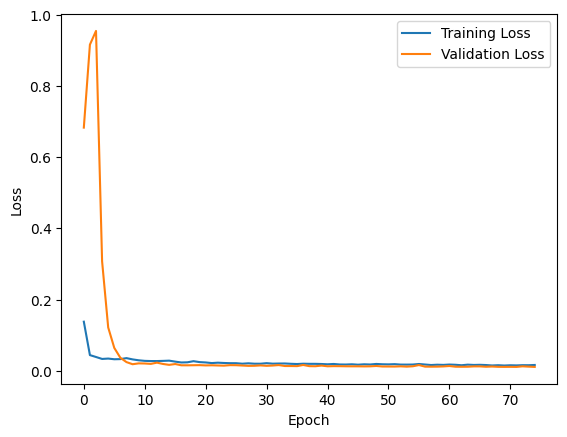

In [156]:
# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [157]:
# Computing the metrics and saving the results

print("Loading the model")

prediction_train = model.predict(x_train, batch_size=16)
prediction_valid = model.predict(x_valid, batch_size=16)
prediction_test = model.predict(x_test, batch_size=16)

print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_test = f1_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice Score")
print(f"F1 Score (Train): {dice_train}, F1 Score (Validation): {dice_valid}, F1 Score (Test): {dice_test}")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_test = jaccard_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou Score")
print(f"IOU (Train): {miou_train}, IOU (Validation): {miou_valid}, IOU (Test): {miou_test}")

precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_test = precision_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                                 np.ndarray.flatten(prediction_test > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision Score")
print(f"Precision Score (Train): {precision_train}, Precision Score (Validation): {precision_valid}, Precision Score (Test): {precision_test}")

recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_test = recall_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                           np.ndarray.flatten(prediction_test > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall Score")
print(f"Recall (Train): {recall_train}, Recall (Validation): {recall_valid}, Recall (Test): {recall_test}")

accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_test = accuracy_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                               np.ndarray.flatten(prediction_test > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))

print("Accuracy finished")
print(f"Accuracy (Train): {accuracy_train}, Accuracy (Validation): {accuracy_valid}, Accuracy (Test): {accuracy_test}")

print("Done!")

Loading the model
4/4 [==============================] - 0s 22ms/step
Predictions done
Dice Score
F1 Score (Train): 0.989248333333979, F1 Score (Validation): 0.9897931618696834, F1 Score (Test): 0.9878767988134846
Miou Score
IOU (Train): 0.9787254040322576, IOU (Validation): 0.9797925776285431, IOU (Test): 0.9760440207826412
Precision Score
Precision Score (Train): 0.9894816485731284, Precision Score (Validation): 0.9897616013726601, Precision Score (Test): 0.9881893587068002
Recall Score
Recall (Train): 0.9890151280982202, Recall (Validation): 0.989824724379508, Recall (Test): 0.9875644365802545
Accuracy finished
Accuracy (Train): 0.9913229395131595, Accuracy (Validation): 0.9916495046307964, Accuracy (Test): 0.9904726089969758
Done!


In [158]:
preds_train = model.predict(x_train, verbose=1)
preds_val = model.predict(x_valid, verbose=1)

2/2 [==============================] - 0s 35ms/step


In [161]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [159]:
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_sample(x, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(x))  # Adjusted index to be within the valid range
    has_mask = y[ix].max() > 0
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(x[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')  # Use grayscale cmap for the actual mask
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap='gray')  # Use viridis cmap for predicted mask
    ax[2].contour(preds[ix].squeeze(), colors='k', levels=[0.5])  # Add contour for better visualization
    ax[2].set_title('Predicted Mask')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1, cmap='viridis')  # Use viridis cmap for binary predicted mask
    ax[3].contour(binary_preds[ix].squeeze(), colors='k', levels=[0.5])  # Add contour for better visualization
    ax[3].set_title('Binary Predicted Mask')

    plt.show()

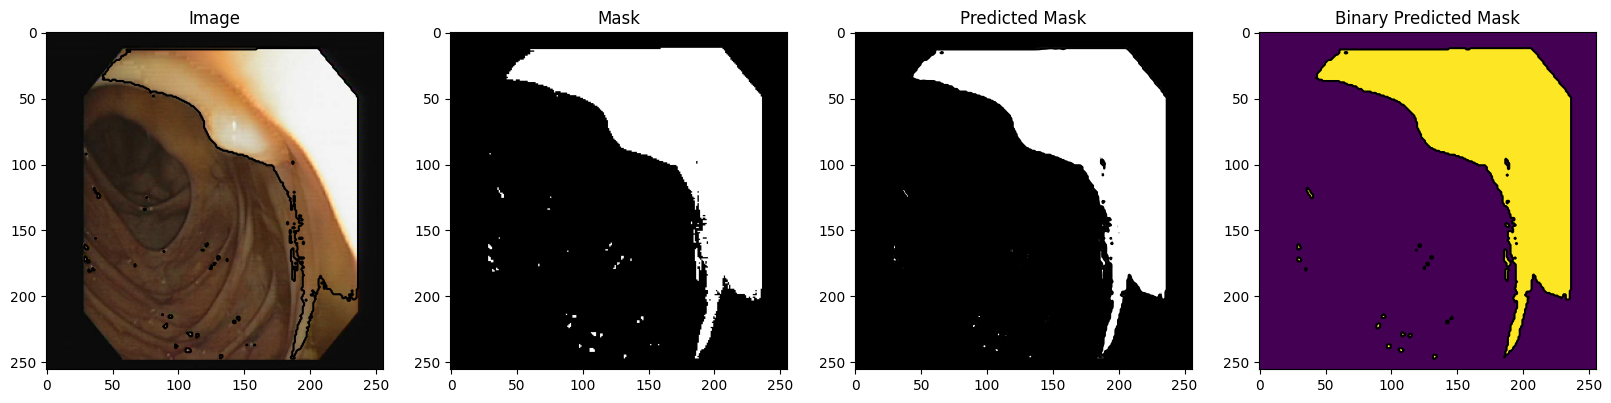

In [162]:
# Call the function with your data
plot_sample(x_valid, y_valid, preds_val, preds_val_t)

# Results Comparison

According to this benchmark: https://paperswithcode.com/sota/medical-image-segmentation-on-cvc-clinicdb

UNet has a mean dice of 0.8230, and ResUnet++ has a mean dice of 0.7955. Attention gate Spatial SE U-net has a test dice of  0.9878767988134846, which is surprisingly high.

For this variant of UNet, Attention Gate Spatial SE U-net is using dense layers and max pooling to connect two convolutional layers while instead simply using activation functions. This connects allows more learning on spatial features like segmentation itself and surrounding pixels around segmentation, thus we have better performance.

# Project Progress Report:

In the development of an advanced university recommendation system, we have explored various cutting-edge methods and technologies to enhance its capabilities. Here's a consolidated overview of our approach, combining initial steps and further enhancements based on the latest research and systematic reviews:

### Initial Approach and Progress

Our primary goal was to replicate and enhance a GitHub project (https://github.com/chinmaysharmacs10/University_Recommender), focusing on data cleaning, preprocessing, and modernizing model architecture with updated packages. This initial step was crucial for maintaining the project's functionality while streamlining it for contemporary users.

### Planned Enhancements

1. **Integration of GRE Scores and Other Academic Indicators**: Incorporating GRE scores, research experience, SOPs, resumes, recommendation letters, and GPAs as part of our feature set to refine our recommendations.
   
2. **Data Clustering for Applicant Insights**: Implementing clustering analysis, such as K-means, to segment applicants based on similar characteristics, enabling more personalized and accurate recommendations.

### Advanced Enhancements Based on State-of-the-Art Research

1. **Evaluation Metrics Beyond Accuracy**: Employing a broad range of metrics like diversity, user satisfaction, and novelty to assess the recommender system's effectiveness in real-world scenarios [oai_citation:1,Frontiers | Developing and Evaluating a University Recommender System](https://www.frontiersin.org/articles/10.3389/frai.2021.796268/full).

2. **Leveraging Learning Analytics**: Analyzing Learning Management Systems (LMS) data for predicting course performance and enhancing personalized recommendations [oai_citation:2,Frontiers | Developing and Evaluating a University Recommender System](https://www.frontiersin.org/articles/10.3389/frai.2021.796268/full).

3. **Adoption of Machine Learning and Deep Learning Techniques**: Utilizing advanced algorithms to address challenges like over-specialization, cold-start, and data sparsity, thus improving the system's accuracy and personalization [oai_citation:3,Applied Sciences | Free Full-Text | State-of-the-Art Survey on Deep Learning-Based Recommender Systems for E-Learning](https://www.mdpi.com/2076-3417/12/23/11996) [oai_citation:4,Electronics | Free Full-Text | Recommendation Systems for Education: Systematic Review](https://www.mdpi.com/2079-9292/10/14/1611).

4. **Hybrid Recommendation Methods**: Combining collaborative filtering, content-based filtering, and machine learning approaches for more robust and effective recommendations [oai_citation:5,Electronics | Free Full-Text | Recommendation Systems for Education: Systematic Review](https://www.mdpi.com/2079-9292/10/14/1611).

5. **Emphasis on Educational Resources**: Focusing on recommending relevant educational resources, courses, and learning paths tailored to the users' academic profiles and needs [oai_citation:6,Electronics | Free Full-Text | Recommendation Systems for Education: Systematic Review](https://www.mdpi.com/2079-9292/10/14/1611).

6. **Context-Aware and Knowledge-Based Recommendations**: Incorporating real-time user contexts and detailed knowledge about users and their needs to enhance the relevance and personalization of recommendations [oai_citation:7,Electronics | Free Full-Text | Recommendation Systems for Education: Systematic Review](https://www.mdpi.com/2079-9292/10/14/1611).

By integrating these features and methodologies, we aim to create a university recommendation system that not only provides more accurate and personalized suggestions but also aligns with the latest advances in recommendation systems and e-learning technologies. Our approach is deeply rooted in current research findings and trends in educational technology, ensuring that our system is both innovative and effective in assisting users with their educational decisions.